In [1]:
%cd /content/drive/MyDrive/Data Mining/9. XGBoost & SHAP

/content/drive/MyDrive/Data Mining/9. XGBoost & SHAP


In [4]:
!pip install shap
!pip install pydataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939416 sha256=3451b9d6b5216d8efab10a513c444d22e09ea9797882e6cae04108070aaa4ad6
  Stored in directory: /root/.cache/pip/wheels/2b/83/5c/073c3755e8b7704e4677557b2055e61026c1a2342149214c13
Successfully built pydataset


In [5]:
import pandas as pd
import xgboost as xgb
from pydataset import data

initiated datasets repo at: /root/.pydataset/


In [7]:
data = data('Housing')
data.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


In [8]:
#remove unnamed variable
data = pd.get_dummies(data, drop_first=True)
data.head()

,price,lotsize,bedrooms,bathrms,stories,garagepl,driveway_yes,recroom_yes,fullbase_yes,gashw_yes,airco_yes,prefarea_yes
1,42000.0,5850,3,1,2,1,True,False,True,False,False,False
2,38500.0,4000,2,1,1,0,True,False,False,False,False,False
3,49500.0,3060,3,1,1,0,True,False,False,False,False,False
4,60500.0,6650,3,1,2,0,True,True,False,False,False,False
5,61000.0,6360,2,1,1,0,True,False,False,False,False,False


In [9]:
#isolate X and y
X = data.drop(['price'], axis=1)
y = data['price']
#
X.head()
#

,lotsize,bedrooms,bathrms,stories,garagepl,driveway_yes,recroom_yes,fullbase_yes,gashw_yes,airco_yes,prefarea_yes
1,5850,3,1,2,1,True,False,True,False,False,False
2,4000,2,1,1,0,True,False,False,False,False,False
3,3060,3,1,1,0,True,False,False,False,False,False
4,6650,3,1,2,0,True,True,False,False,False,False
5,6360,2,1,1,0,True,False,False,False,False,False


In [10]:
#Create Train and Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1502)
#
X_test.head()

,lotsize,bedrooms,bathrms,stories,garagepl,driveway_yes,recroom_yes,fullbase_yes,gashw_yes,airco_yes,prefarea_yes
471,2145,3,1,3,1,True,False,False,False,False,True
430,3600,3,1,1,0,True,False,True,False,True,True
95,8050,3,1,1,1,True,True,True,False,True,False
223,4200,3,1,2,1,True,False,False,False,False,False
286,2550,3,1,2,0,True,False,True,False,False,False


In [11]:
#Create XGBoost matrices
Train = xgb.DMatrix(X_train, label=y_train)
Test = xgb.DMatrix(X_test, label=y_test)
#

In [12]:
#XGBoost
#Parameters
parameters ={'learing_rate': 0.3,
             'max_depth':6,
             'colsample_bytree': 1,
             'subsample': 1,
             'min_child_weight': 1,
             'gamma': 0,
             'random_state': 1502,
             'eval_metric': 'rmse',
             'objective': 'reg:squarederror'}

In [13]:
#XGBoost Model
model = xgb.train(params = parameters,dtrain = Train, num_boost_round=15, evals = [(Test, 'Price')], verbose_eval = 2)

[0]	Price-rmse:24752.51165
[2]	Price-rmse:20570.72330
[4]	Price-rmse:18923.09047
[6]	Price-rmse:18356.81541
[8]	Price-rmse:18347.56022
[10]	Price-rmse:18212.61102
[12]	Price-rmse:18205.53691
[14]	Price-rmse:18020.41633


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "learing_rate" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
#Predictions
predictions = model.predict(Test)
predictions[:5]

array([60054.56 , 62767.54 , 82207.1  , 56638.99 , 45007.176],
      dtype=float32)

In [18]:
#Model assessment
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
print(round(mean_absolute_error(y_test, predictions),0))
print(round(mean_squared_error(y_test, predictions),0))
print(round(np.sqrt(mean_squared_error(y_test, predictions)),0))

12876.0
324735401.0
18020.0


In [19]:
#SHAP
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [20]:
#Local Interpretability
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.loc[144])

In [21]:
X_test.head()

,lotsize,bedrooms,bathrms,stories,garagepl,driveway_yes,recroom_yes,fullbase_yes,gashw_yes,airco_yes,prefarea_yes
471,2145,3,1,3,1,True,False,False,False,False,True
430,3600,3,1,1,0,True,False,True,False,True,True
95,8050,3,1,1,1,True,True,True,False,True,False
223,4200,3,1,2,1,True,False,False,False,False,False
286,2550,3,1,2,0,True,False,True,False,False,False


In [22]:
shap_values

array([[-16916.229   ,   1211.991   ,  -3141.1694  , ...,   -531.33307 ,
         -2629.3237  ,   3209.1392  ],
       [ -8241.305   ,    125.604004,  -4909.697   , ...,   -380.7603  ,
          5642.358   ,   7404.5244  ],
       [ 10611.568   ,  -2848.7534  ,  -6124.995   , ...,   -249.68481 ,
          6735.6416  ,  -1072.0684  ],
       ...,
       [ 10092.622   ,    487.61636 ,  11645.13    , ...,   -148.87991 ,
          5825.464   ,   5676.1294  ],
       [ -1485.301   ,    873.89    ,   9988.552   , ...,   -160.49744 ,
          9608.141   ,   4163.4717  ],
       [ 23173.654   ,   1863.3206  ,  -5488.3296  , ...,   -219.73953 ,
         -2128.731   ,   -546.4801  ]], dtype=float32)

In [23]:
#all individual predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

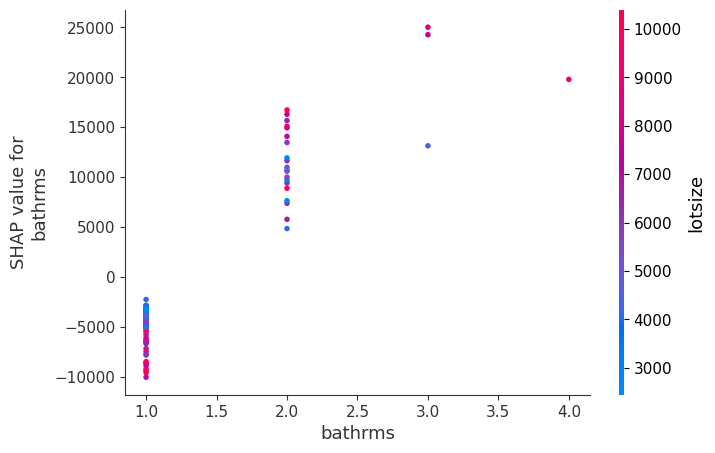

In [25]:
#dependecy plots
shap.dependence_plot('bathrms', shap_values, X_test)

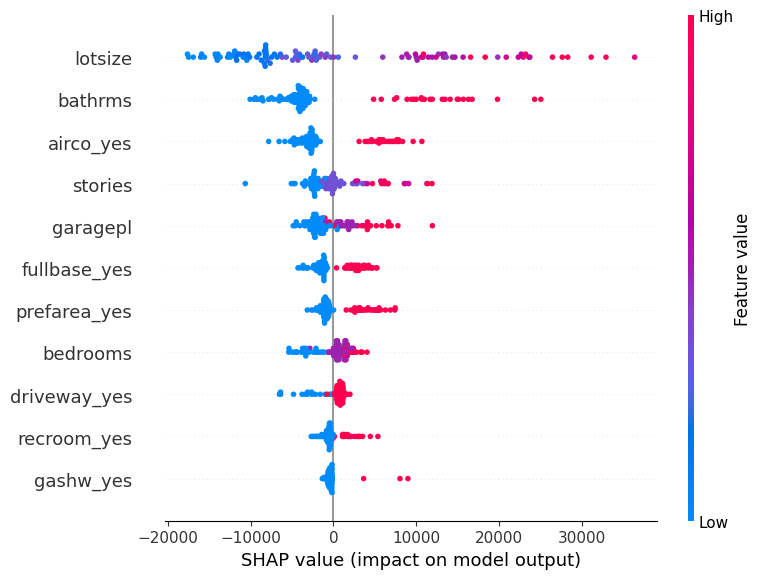

In [26]:
#Summary plot
shap.summary_plot(shap_values, X_test)